In [6]:
import numpy as np
import pandas as pd 
from scipy.optimize import least_squares
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

In [59]:
dQI = pd.read_csv('DataForImpact/dQI.csv', index_col=False) 
dQI, dQI_test = train_test_split(dQI, test_size = 0.1, shuffle=False)

In [61]:
dQI = dQI.loc[dQI["DeltaQ"] > 0]

In [63]:
dQI.to_csv("DataForImpact/dQI.csv")

### GOW model

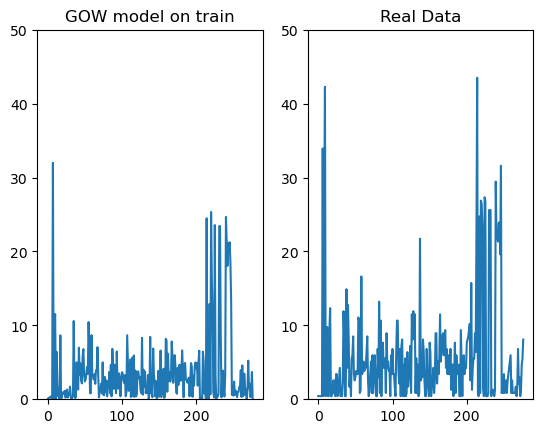

4.260170149330982


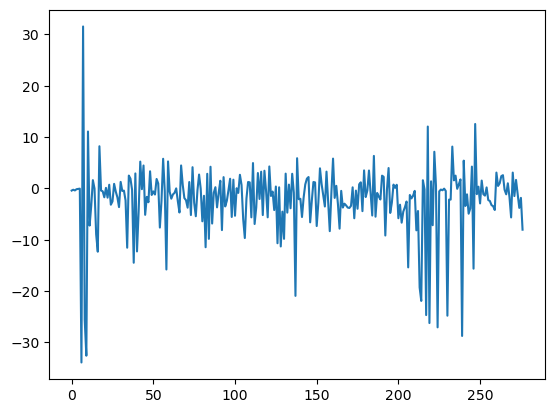

In [33]:
MI = np.array(dQI[' Impact'])
dQ= np.array(dQI[' DeltaQ'])
T = np.array(dQI['Time'])


# Модель 0. Это попробовали:  I_{t+1} = I_{t} * \rho^{t_{i+1} - t_i} + \lamda * dQ

# Модель 1. Описание ниже:
# Всё безобразие сделать в R
# dQ = dQ / (t_{i+1} - t_i)
# Нужно так пересчитать маркет импакт: I_{t+1} = log(S_{t_{i+1}}/S_{t_{i}}) / (t_{i+1} - t_i)
# I_{t+1} = I_{t} * \rho + \lamda * dQ

# Модель 2:
# I_{t+1} = log(S_{t_{i+1}}/S_{t_{i}}) / (dQ_{i+1})
# I_{t+1} = I_{t} * \alpha + \lamda (Можно автоариму попробовать)

# Модель 3. Это попробовали:  I_{t+1} = I_{t} * \rho^{t_{i+1} - t_i} + \lamda * dQ


def fun(x, mi: np.array, mi_prev: np.array, dq: np.array, dt: np.array):
            return np.power(x[0], dt) * mi_prev + x[1] * dq - mi


res_lsq = least_squares(fun, np.array([1., 0.5]), args=(MI[1:], MI[:-1], dQ[1:], np.diff(T)))

Ipred = np.power(res_lsq.x[0], np.diff(T)) * MI[:-1] + res_lsq.x[1] * dQ[:-1]

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)
plt.title("GOW model on train")
plt.ylim(0, 50)
plt.subplot(122)
plt.plot(np.arange(len(MI[1:])), np.array(MI[1:]))
plt.ylim(0, 50)
plt.title("Real Data")

plt.show()

plt.plot(res_lsq.fun)

print(sum(abs(res_lsq.fun)) / len(res_lsq.fun))

In [34]:
print(res_lsq)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-4.076e-01 -2.459e-01 ... -1.835e+00 -8.033e+00]
           x: [ 9.709e-01  1.273e-04]
        cost: 7016.481381110963
         jac: [[ 2.170e+00  7.029e+00]
               [ 5.439e+00  7.029e+00]
               ...
               [ 3.044e+01  7.029e+00]
               [ 7.523e+00  4.217e-01]]
        grad: [ 2.877e-01  1.283e-03]
  optimality: 0.28769492393557844
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 10
        njev: 10


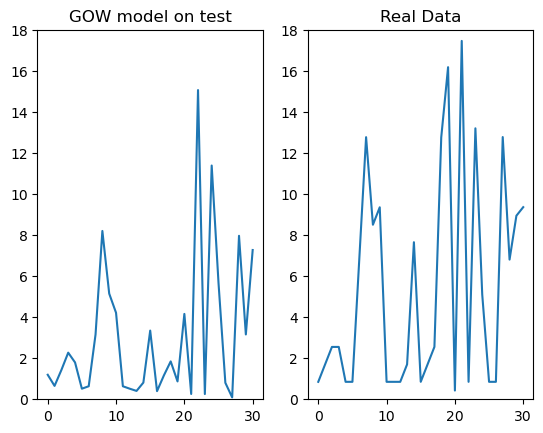

Average percent of mistake:  1.740586738578975


In [35]:
MI = np.array(dQI_test[' Impact'])
dQ= np.array(dQI_test[' DeltaQ'])
T = np.array(dQI_test['Time'])

Ipred = np.power(res_lsq.x[0], np.diff(T)) * MI[:-1] + res_lsq.x[1] * dQ[:-1]

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)
plt.ylim(0, 18)
plt.title("GOW model on test")
plt.subplot(122)
plt.plot(np.arange(len(MI[1:])), np.array(MI[1:]))
plt.ylim(0, 18)
plt.title("Real Data")

plt.show()

print('Average percent of mistake: ', sum(abs((Ipred - MI[1:])/MI[1:])) / len(Ipred))

### Square root model

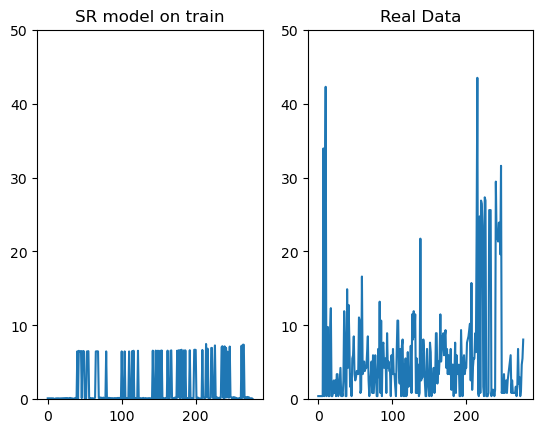

5.599210566607599


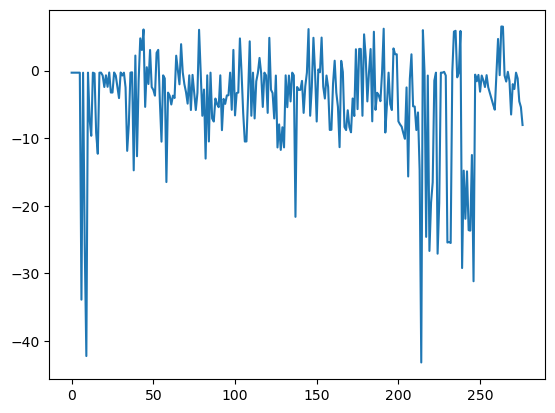

In [36]:
MI = np.array(dQI[' Impact'])
dQ= np.array(dQI[' DeltaQ'])
T = np.array(dQI['Time'])

def fun(x, mi: np.array, dq: np.array):
            return x[0] * np.power(dq, 0.5) - mi 

res_lsq = least_squares(fun, np.array([1.]), args=(MI[1:], dQ[1:])) # могли упасть в локальный минимум


Ipred = res_lsq.x[0] * np.power(dQ, 0.5)

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)
plt.ylim(0, 50)
plt.title("SR model on train")
plt.subplot(122)
plt.plot(np.arange(len(MI)), np.array(MI))
plt.ylim(0, 50)
plt.title("Real Data")

plt.show()

plt.plot(res_lsq.fun) 
print(sum(abs(res_lsq.fun)) / len(res_lsq.fun))

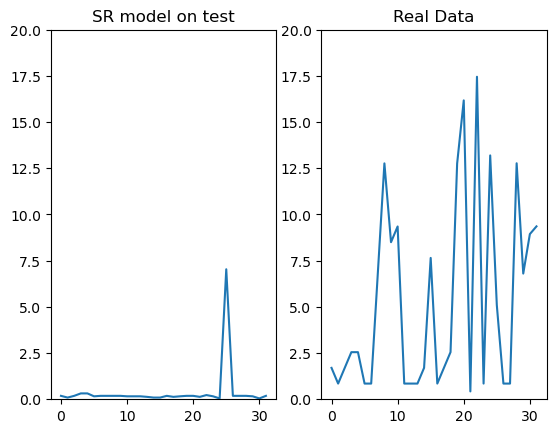

Average percent of mistake:  0.8848773754868592


In [37]:
MI = np.array(dQI_test[' Impact'])
dQ= np.array(dQI_test[' DeltaQ'])
T = np.array(dQI_test['Time'])

Ipred = res_lsq.x[0] * np.power(dQ, 0.5)

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)
plt.ylim(0, 20)
plt.title("SR model on test")
plt.subplot(122)
plt.plot(np.arange(len(MI)), np.array(MI))
plt.ylim(0, 20)
plt.title("Real Data")

plt.show()

print('Average percent of mistake: ', sum(abs((Ipred - MI)/MI)) / len(Ipred))

### ARX(2, 1)

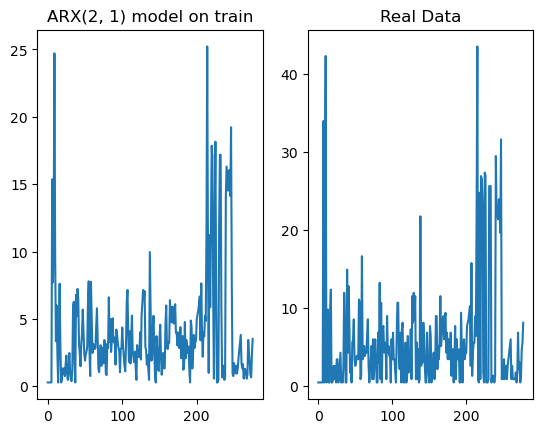

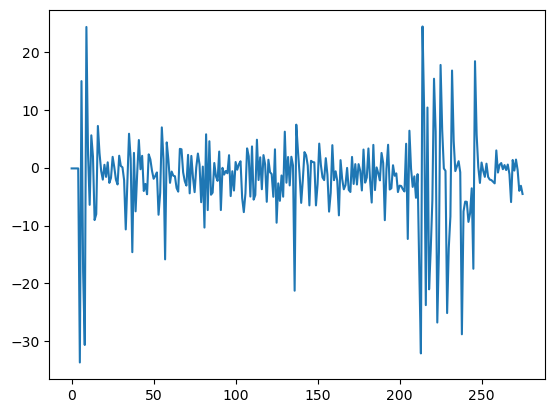

In [38]:
MI = np.array(dQI[' Impact'])
dQ= np.array(dQI[' DeltaQ'])
T = np.array(dQI['Time'])


def fun(x, mi: np.array, mi_prev: np.array, mi_prev_prev:np.array, dq: np.array):
            return x[0] * mi_prev + x[1] * mi_prev_prev +  x[2] * dq - mi

res_lsq = least_squares(fun, np.array([1., 0.5, 1.]), args=(MI[2:], MI[1:-1], MI[:-2], dQ[:-2]))

Ipred = res_lsq.x[0] * MI[1:-1] + res_lsq.x[1] * MI[:-2] +  res_lsq.x[2] * dQ[:-2]

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)

plt.title("ARX(2, 1) model on train")
plt.subplot(122)
plt.plot(np.arange(len(MI)), np.array(MI))

plt.title("Real Data")

plt.show()

plt.plot(res_lsq.fun) 

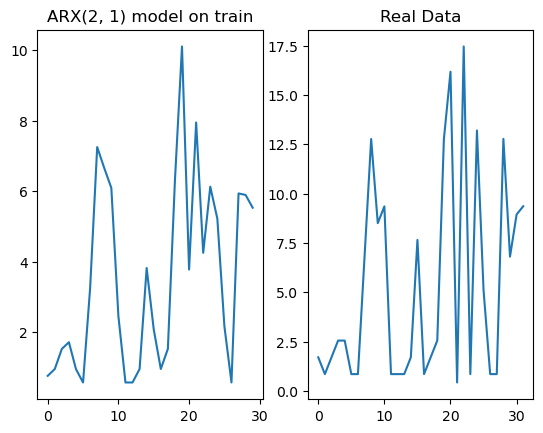

Average percent of mistake:  2.436454952936584


In [39]:
MI = np.array(dQI_test[' Impact'])
dQ= np.array(dQI_test[' DeltaQ'])
T = np.array(dQI_test['Time'])

Ipred = res_lsq.x[0] * MI[1:-1] + res_lsq.x[1] * MI[:-2] +  res_lsq.x[2] * dQ[:-2]

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)

plt.title("ARX(2, 1) model on train")
plt.subplot(122)
plt.plot(np.arange(len(MI)), np.array(MI))

plt.title("Real Data")

plt.show()

print('Average percent of mistake: ', sum(abs((Ipred - MI[2:])/Ipred)) / len(Ipred))

### Experiments

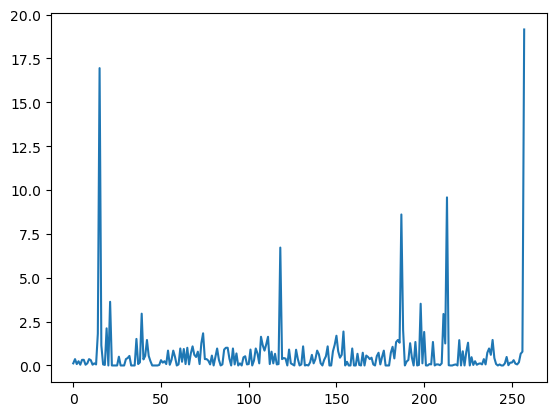

In [49]:
MI = np.array(dQI[' Impact'])
dQ= np.array(dQI[' DeltaQ'])
T = np.array(dQI['Time'])

plt.plot((MI/dQ)[20:])

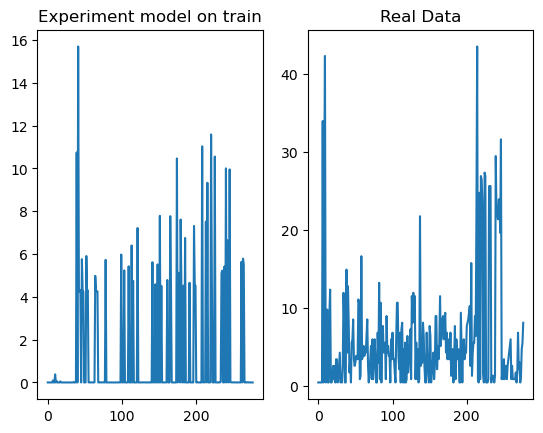

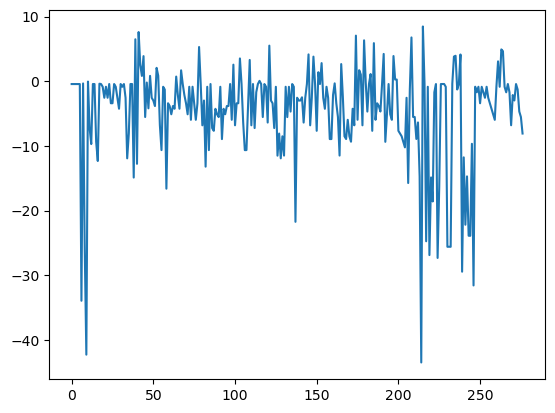

In [42]:
# Модель 0. Это попробовали:  I_{t+1} = I_{t} * \rho^{t_{i+1} - t_i} + \lamda * dQ

# Модель 1. Описание ниже:
# Всё безобразие сделать в R
# dQ = dQ / (t_{i+1} - t_i)
# Нужно так пересчитать маркет импакт: I_{t+1} = log(S_{t_{i+1}}/S_{t_{i}}) / (t_{i+1} - t_i)
# I_{t+1} = I_{t} * \rho + \lamda * dQ

# Модель 2:
# I_{t+1} = log(S_{t_{i+1}}/S_{t_{i}}) / (dQ_{i+1})
# I_{t+1} = I_{t} * \alpha + \lamda (Можно автоариму попробовать)

# Мсследовать её эконометрически
def fun(x, mi: np.array, mi_prev: np.array, dq: np.array, dq_prev: np.array):
            return (x[0] * mi_prev / dq_prev + x[1]) * dq - mi

res_lsq = least_squares(fun, np.array([0., 2.]), args=(MI[1:], MI[:-1], dQ[1:], dQ[:-1]))

Ipred = (res_lsq.x[0] * MI[:-1] / dQ[:-1] + res_lsq.x[1]) * dQ[1:]

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)

plt.title("Experiment model on train")
plt.subplot(122)
plt.plot(np.arange(len(MI[1:])), np.array(MI[1:]))
plt.title("Real Data")

plt.show()

plt.plot(res_lsq.fun)

In [48]:
res_lsq

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.448e+01  4.070e+00 ... -2.247e+00  1.411e+00]
           x: [ 7.390e-01  6.311e-02]
        cost: 41088.37603252735
         jac: [[ 8.695e+01  2.045e+02]
               [ 6.296e+01  2.054e+02]
               ...
               [ 8.340e+01  3.969e+02]
               [ 9.247e+01  4.127e+02]]
        grad: [ 1.063e-03  8.638e-03]
  optimality: 0.00863816871878953
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 4
        njev: 2

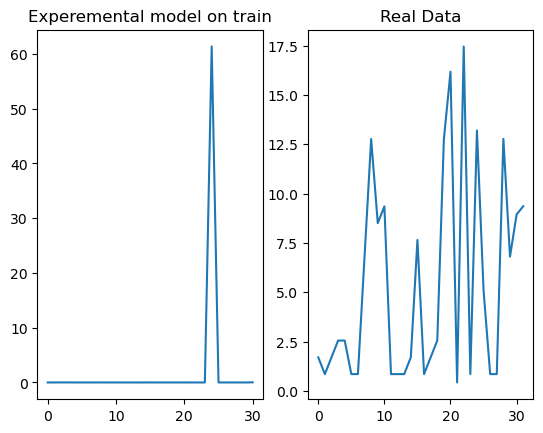

Average percent of mistake:  4065.5609683680964


In [44]:
MI = np.array(dQI_test[' Impact'])
dQ= np.array(dQI_test[' DeltaQ'])
T = np.array(dQI_test['Time'])

Ipred =  (res_lsq.x[0] * MI[:-1] / dQ[:-1] + res_lsq.x[1]) * dQ[1:]

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)
plt.title("Experemental model on train")
plt.subplot(122)
plt.plot(np.arange(len(MI)), np.array(MI))
plt.title("Real Data")

plt.show()

print('Average percent of mistake: ', sum(abs((Ipred - MI[1:])/Ipred)) / len(Ipred))

### Скользящее окно

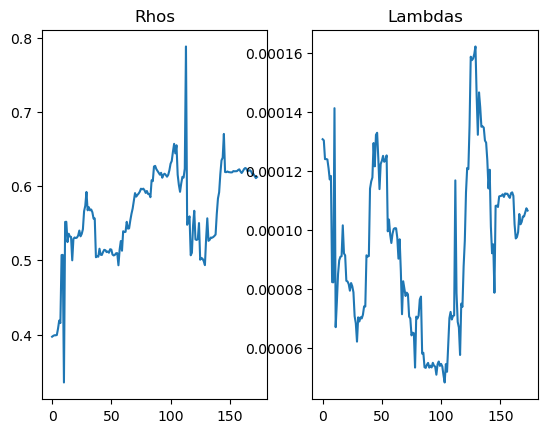

In [65]:
def fun(x, mi: np.array, mi_prev: np.array, dq: np.array, dt: np.array):
    return x[0] * mi_prev + x[1] * dq - mi

rhos = np.array([])
lambdas = np.array([])

wind = 100

for i in range(len(MI) - 4 - wind):    
    res_lsq = least_squares(fun, np.array([0., 2.]), args=(MI[(i + 1):(i + 3 + wind)], MI[i:(i + 2 + wind)], dQ[(i + 1):(i + 3 + wind)], dQ[i:(i + 2 + wind)]))
    rhos = np.append(rhos, res_lsq.x[0])
    lambdas = np.append(lambdas, res_lsq.x[1])

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(rhos)), rhos)
plt.title("Rhos")

plt.subplot(122)
plt.plot(np.arange(len(lambdas)), lambdas)
plt.title("Lambdas")


plt.show()

Задачи на слудующий раз:
1. Реализовать модель выше в R
2. Причесать дату
3. Скользящее окно
4. Посмотреть статьи по предсказанию маркет импакта